In [ ]:
#!pip install rouge_score bert_score
import nltk
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from transformers import AutoTokenizer, AutoModelForCausalLM
from bert_score import score as bert_score_fn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,  confusion_matrix, classification_report)
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, Trainer, TrainingArguments
from transformers import TextDataset, DataCollatorForLanguageModeling

#1. EvaluateModel

## i. Dataset Structure Instruction
### a. Classification Model Evaluation
dataset = {

    "prompts": ["", "", "", ...], #List of the text,
    "labels": ["AI", "Human", "neutral", ...],  # Ground-truth labels (can be int or str)
    "predictions": ["positive", "positive", "neutral", ...]  # Predicted labels (same format as `label`)
}

We can evaluate the model as
```
evaluator = EvaluateModel(dataset=dataset)
evaluator.evaluate_classification_model(average='macro',print_result)
```
The function already support label encoding automatically if your labels are strings.


### b. Generative Model Evaluation

```
dataset = {
    "reference_texts": [
        ["The cat sat on the mat.", "A cat is sitting on a mat."],
        ["Hello, how are you?"]
        # Each item is a list of reference texts
    ],
    "generated_texts": [
        "The cat is sitting on the mat.",
        "Hi, how do you do?"
        # Each item is a generated hypothesis
    ]
}
```
We can evaluate the model as


```
evaluator = EvaluateModel(dataset=dataset)
evaluator.evaluate_generative_model(metrics=['bleu', 'rouge', 'bertscore'], print_result=True) # Head to the functio to see more detail
```

In [ ]:
class EvaluateModel():
  def __init__(self, dataset=None, model=None, tokenizer=None) -> None:
      self.model = model
      self.tokenizer = tokenizer
      self.results = {}
      self.device = ( "cuda" if torch.cuda.is_available()
                    else "mps" if torch.backends.mps.is_available()
                    else "cpu")

      self.dataset = dataset

  #Check the labels is int and encode it if it is string
  def encode_labels(self, col):
      try:
          int_labels = [int(x) for x in self.dataset[col]]
          label_names = sorted(set(int_labels))
      except ValueError:
          le = LabelEncoder()
          encoded_labels = le.fit_transform(self.dataset[col])
          int_labels = encoded_labels
          label_names = sorted(set(encoded_labels))  # integer labels only

          print(f"The {col} labels have been encoded. Integer mapping:")
          for original, encoded in zip(le.classes_, le.transform(le.classes_)):
              print(f"{original} -> {encoded}")

      return int_labels, label_names

  #Compute the BLEU score
  def bleu_score(self, reference_texts, generated_text):
      ref_tokens = [ref.split() for ref in reference_texts]
      gen_tokens = generated_text.split()
      smoothie = SmoothingFunction().method1
      bleu = sentence_bleu(ref_tokens, gen_tokens, smoothing_function=smoothie)
      return {'bleu': bleu}

  #Compute the ROUGE score
  def rouge_score(self, reference_texts, generated_text):
      scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
      scores = [scorer.score(ref, generated_text) for ref in reference_texts]
      avg_scores = {
          k: np.mean([s[k].fmeasure for s in scores]) for k in scores[0]
      }
      return avg_scores

  #Compute the BERTScore
  def bert_score(self, reference_texts, generated_text, model_type_ = 'bert-base-uncased'):
      P, R, F1 = bert_score_fn([generated_text], [reference_texts], model_type=model_type_)
      return {
          'bertscore_precision': P.mean().item(),
          'bertscore_recall': R.mean().item(),
          'bertscore_f1': F1.mean().item()
      }

  #Evaluate the clasification model
  def evaluate_classification_model(self, average='macro', print_result=True):
      """
      Evaluate a classification model using standard metrics:
      - Accuracy, Precision, Recall, F1-score, Confusion Matrix

      Args:
          average (str): Averaging method for multi-class ('binary', 'micro', 'macro').
          print_result (bool): Whether to print results and plot confusion matrix.

      Workflow:
          - Checks for 'label' and 'prediction' keys in dataset.
          - Encodes non-integer labels if necessary.
          - Computes classification metrics.
          - Optionally prints a classification report and confusion matrix.
      """
      if any(k not in self.dataset for k in ["labels", "predictions"]):
          print("Please provide the dataset with 'label' and 'prediction' columns.")
          return

      # Encode labels (handles string → int mapping if needed)
      targets, label_names_target = self.encode_labels("labels")
      predictions, label_names_prediction = self.encode_labels("predictions")

      label_names = label_names_target
      print(targets)
      print(predictions)
      print(label_names)
      # Compute evaluation metrics
      acc = accuracy_score(targets, predictions)
      prec = precision_score(targets, predictions, average=average, zero_division=0)
      rec = recall_score(targets, predictions, average=average, zero_division=0)
      f1 = f1_score(targets, predictions, average=average, zero_division=0)
      cm = confusion_matrix(targets, predictions, labels=label_names)

      # Optionally print results
      if print_result:
          plt.figure(figsize=(6, 5))
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
          plt.xlabel('Predicted')
          plt.ylabel('Actual')
          plt.title('Confusion Matrix')
          plt.show()

          print(f"Accuracy: {acc:.4f}")
          print(f"F1-score: {f1:.4f}")
          print(f"Recall: {rec:.4f}")
          print(f"Precision: {prec:.4f}")
          print("\nClassification Report:")
          print(classification_report(targets, predictions, labels=label_names, zero_division=0))

      # Store results
      self.results.update({
          "accuracy": acc,
          "precision": prec,
          "recall": rec,
          "f1_score": f1,
          "confusion_matrix": cm,
      })


  def evaluate_generative_model(self, metrics=['bleu', 'rouge', 'bertscore'], print_result = True, bert_model='bert-base-uncased'):
      """
      Evaluate a generative model using metrics like BLEU, ROUGE, and BERTScore.

      Args:
          metrics (list): List of metrics to compute. Options: 'bleu', 'rouge', 'bertscore'.
          bert_model (str): Hugging Face model name to use for BERTScore.

      Workflow:
          - Validates that 'reference_texts' and 'generated_texts' are in the dataset.
          - Loops over each pair of reference and generated text.
          - Computes and stores selected metrics.
      """
      if "reference_texts" not in self.dataset or "generated_texts" not in self.dataset:
          print("Please provide 'reference_texts' and 'generated_texts' in the dataset.")
          return

      refs = self.dataset['reference_texts'].copy()
      gens = self.dataset['generated_texts'].copy()

      for ref, gen in zip(refs, gens):
          # Expect `ref` to be a list of strings, `gen` to be a single string
          if 'bleu' in metrics:
              self.results.update(self.bleu_score(ref, gen))
          if 'rouge' in metrics:
              self.results.update(self.rouge_score(ref, gen))
          if 'bertscore' in metrics:
              self.results.update(self.bert_score(ref, gen, bert_model))

      if print_result:
          print("Generative Model Evaluation Results:")
          for metric, score in self.results.items():
              print(f"{metric:20}: {score:.4f}")

# 2. Testing stage

## a. Testing generateive metrics without loading dataset

In [ ]:
reference = "The quick brown fox jumps over the lazy dog"
generated = "The fast brown fox jumps over a lazy dog"

evaluateModel = EvaluateModel()

bert = evaluateModel.bert_score(
    reference_texts=reference,
    generated_text=generated,
)

bleu = evaluateModel.bleu_score(
    reference_texts=reference,
    generated_text=generated
)

rouge = evaluateModel.rouge_score(
    reference_texts=reference,
    generated_text=generated
)
print(bleu)
print(rouge)
print(bert)

{'bleu': 0.023980296761827107}
{'rouge1': np.float64(0.004651162790697674), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.004651162790697674)}
{'bertscore_precision': 0.9204388856887817, 'bertscore_recall': 0.9204388856887817, 'bertscore_f1': 0.9204388856887817}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


## b. Testing the classification metrics with full evaluation dataset


The original labels have been encoded. Integer mapping:
AI -> 0
Human -> 1
The original labels have been encoded. Integer mapping:
AI -> 0
Human -> 1
[1 0 1]
[0 0 1]
[np.int64(0), np.int64(1)]


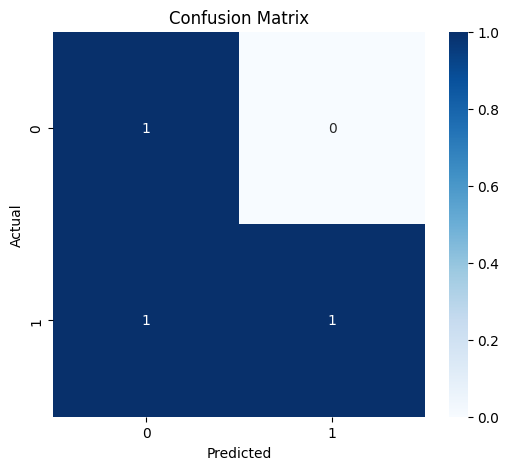

Accuracy: 0.6667
F1-score: 0.6667
Recall: 0.5000
Precision: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.50      0.67         2

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



In [ ]:
dataset = {
    "prompt": [
        "The quick brown fox jumps over the lazy dog.",
        "Neural networks can approximate any function.",
        "I had coffee this morning and read the news."
    ],
    "label": [
        "Human",
        "AI",
        "Human"
    ],
    "prediction": [
        "AI",
        "AI",
        "Human"
    ]
}

evaluateModel = EvaluateModel(dataset=dataset)
evaluateModel.evaluate_classification_model()

## c. Testing the Generative model with full dataset

In [ ]:
dataset = {
    "reference_texts": [
        "The quick brown fox jumps over the lazy dog.",
        "Neural networks can approximate any function.",
        "I had coffee this morning and read the news."
    ],
    "generated_texts": [
        "The quick red fox jumps over the lazy dog.",
        "Neural networks could approximate any function.",
        "I have coffee this morning and read the news."
    ]
}


evaluateModel = EvaluateModel(dataset=dataset)
evaluateModel.evaluate_generative_model()

Generative Model Evaluation Results:
bleu                : 0.0240
rouge1              : 0.0136
rouge2              : 0.0000
rougeL              : 0.0136
bertscore_precision : 0.9596
bertscore_recall    : 0.9596
bertscore_f1        : 0.9596


# 3. Experiment Setup for the AI Detection Model

In [ ]:
def classify_text(model, tokenizer, device, text, few_shot_prompt, max_new_tokens=10):
    # Insert the new text into the few-shot prompt
    prompt = few_shot_prompt.format(text)

    # Tokenize and send to device
    input_ids = tokenizer(prompt, return_tensors="pt").to(device)
    output_ids = model.generate(**input_ids, max_new_tokens=max_new_tokens)

    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # Extract the label predicted after the last 'Label:' token
    # For example, output may be the full prompt + " AI" or " Human"
    label = generated_text.split("Label:")[-1].strip().split()[0]

    return label

In [ ]:
few_shot_prompt = """
Decide whether the following text was written by a human or an AI.

Text: "Artificial intelligence is a powerful tool for automating tasks."
Label: AI

Text: "I walked to the market this morning and bought fresh bread."
Label: Human

Text: "The moon is a celestial body that orbits Earth."
Label: AI

Text: "Yesterday, I enjoyed a long walk in the park."
Label: Human

Text: "Machine learning models improve with more data."
Label: AI
"""

In [ ]:
dataset = {
    "prompt": [
        "The quick brown fox jumps over the lazy dog.",
        "Neural networks can approximate any function.",
        "I had coffee this morning and read the news."
    ],
    "labels": [
        "Human",
        "AI",
        "Human"
    ]
}

#Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype=torch.float16, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
pred_label_ls = []

#Run the model and get the label
for i, text in enumerate(dataset["prompt"]):
    pred_label = classify_text(model, tokenizer, device, text, few_shot_prompt)
    pred_label_ls.append(pred_label)
    print(f"Text: {text}")
    print(f"Predicted Label: {pred_label} | Actual Label: {dataset['labels'][i]}")
    print()

#Store the prediction to dataset
dataset['predictions'] = pred_label_ls

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Text: The quick brown fox jumps over the lazy dog.
Predicted Label: AI | Actual Label: Human



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Text: Neural networks can approximate any function.
Predicted Label: AI | Actual Label: AI

Text: I had coffee this morning and read the news.
Predicted Label: AI | Actual Label: Human



The labels labels have been encoded. Integer mapping:
AI -> 0
Human -> 1
The predictions labels have been encoded. Integer mapping:
AI -> 0
[1 0 1]
[0 0 0]
[np.int64(0), np.int64(1)]


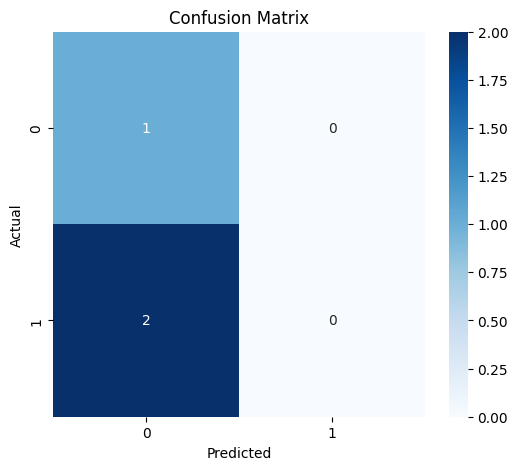

Accuracy: 0.3333
F1-score: 0.2500
Recall: 0.5000
Precision: 0.1667

Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         2

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



In [ ]:
evaluateModel = EvaluateModel(dataset=dataset)
evaluateModel.evaluate_classification_model()